#**LG AI해커톤**

> **MQL 데이터 기반 B2B 영업기회 창출 예측 모델 개발**
</br>Team_Gramers (하성민, 권성준, 윤서영)
</br>



## **Concepts**
1.   [데이터 확인](#1.-데이터-확인)<br/>
2.   [데이터 전처리](#2.-데이터-전처리)<br/>
3.   [학습에 사용할 칼럼 정의](#3.-학습에-사용할-칼럼-정의)<br/>
4.   [모델 정의](#4.-모델-정의)<br/>
5.   [모델 학습 및 평가](#5.-모델-학습-및-평가)<br/>

# 1. 데이터 확인 <a name="1.-데이터-확인"></a>


> 사용할 모델(DeepFM)과 모델 개발 과정에 필요한 라이브러리를 불러옵니다.



### 1.1 필수 라이브러리

In [68]:
#!pip install tensorflow==2.8.0

In [69]:
#!pip install deepctr

In [70]:
#!pip install deepctr_torch

In [71]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random
import os
import torch

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

### 1.2 DeepFM 모델 관련 라이브러리

In [72]:
from deepctr.layers import FM, DNN
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

from deepctr.models.xdeepfm import xDeepFM

from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

### 1.3 랜덤 시드 고정

In [73]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(7579) # Seed 고정

### 1.4 데이터 셋 읽어오기

> 훈련용 데이터 셋과 제출용 데이터 셋을 불러옵니다.

- 훈련 데이터에서 모든 값이 똑같은 **중복값 3519개를 제거**하여,
<br/>총 훈련 데이터 59299개 중 55780개의 데이터를 보존하였습니다.



In [74]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_train.drop_duplicates(inplace=True) # 중복값 제거

df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

# 2. 데이터 전처리<a name="2.-데이터-전처리"></a>

> 주어진 데이터의 각 칼럼들의 특징을 분석하고, DeepFM모델 훈련에 알맞은 형태로 가공합니다.



## 2.0 EDA시 필요한 함수 정의

### 2.0.1 칼럼 별 결측치 개수와 비율 출력 함수

In [75]:
# 칼럼 별 결측치 개수와 비율 출력 함수 정의
def calculate_missing_values(df, column_name):
    """
    특정 칼럼의 결측치 개수와 비율을 구함
    df의 column_name 칼럼에서
    결측치 개수 missing_count와 비율 missing_percentage을 계산
    스트링으로 반환
    """
    missing_count = df[column_name].isna().sum()
    total_count = df.shape[0]
    missing_percentage = (missing_count / total_count) * 100
    return f"{column_name} 칼럼의 결측 개수: {missing_count}, 비율: {missing_percentage:.2f}%"

### 2.0.2 col 칼럼의 데이터 유형별 전환율 확인 함수

In [76]:
def show_conversion_ratio(col:str, cnt=False):
    '''
    col 칼럼의 데이터 유형별 전환율을 확인한다.
    칼럼의 데이터 유형이 많을 경우, 상위 cnt 개 만큼의 전환율을 확인한다.
    '''

    if cnt:
        find = df_train[col].value_counts()[:cnt]
    else:
        find = df_train[col].value_counts()



    total = len(df_train) - df_train[col].isnull().sum()
    print(f"총 고객 : {len(df_train)}")
    print(f"작성된 고객 유형 : {total}")
    missing_value = round(df_train[col].isnull().sum()/len(df_train),2)
    print(f"결측치 비율 = {missing_value}")
    print('\n\n')

    print(f"{'=====고객 별 비율=====':<35} {'  ===고객 별 전환비율====='}")

    for name, count in zip(find.index, find):
        print(f'{name :<30} : {round(count/total*100,2):<5} %', end = '')
        filter = df_train[col]== name
        convert = df_train[filter]['is_converted'].sum()
        convertion_ratio = convert / count
        print(f"    고객 {count:<5} 중 {convert:<5} : {round(convertion_ratio*100,2)}")


## 2.1. expected_timeline



> **'expected_timeline'** 은 **고객의 요청한 처리 일정**에 관한 정보로, 문자열로 이루어져 있습니다.


### 2.1.1 결측치 확인


> 결측치: 28292개 (50.72%)

In [77]:
# 결측치 개수와 비율 확인
expected_timeline_missing_value = calculate_missing_values(df_train, 'expected_timeline')
expected_timeline_missing_value

'expected_timeline 칼럼의 결측 개수: 28292, 비율: 50.72%'

### 2.1.2 데이터 구성 확인


> - 데이터 탐색 과정을 통해 **'expected_timeline'** 은 '3 months ~ 6 months'처럼 기간으로만 깔끔하게 이루어진 칼럼이 아니라는 것을 확인했습니다.
<br/>
- 또한, 'no budgets for now wont buy'와 같이 **칼럼 값에 특정 단어들이 lead에 대한 중요한 정보를 포함**하는 것을 확인하였습니다.
<br/>
- Ex) 'demo'라는 단어는 'demo reqest', 'follow'는 'follow up'의 맥락에서 사용됨



In [78]:
# 데이터 구성 확인
df_train['expected_timeline'].value_counts()

less than 3 months                                                                                                            16768
3 months ~ 6 months                                                                                                            4798
more than a year                                                                                                               2874
9 months ~ 1 year                                                                                                              1070
6 months ~ 9 months                                                                                                            1043
                                                                                                                              ...  
no requirement of this time                                                                                                       1
not reachable , lead shared with partner                                    

### 2.1.3 전처리

> 칼럼 값들을 'less than 3 months' 부터 'more than a year'로 기간으로 분류한 뒤 남은 값들은 주요 단어를 기준으로 분류하였습니다.

*   분류되지 않고 빈도수가 낮은 데이터는 'etc'로 분류합니다.
*   결측치는 'no comment'로 채워 넣습니다.
*   분류 후 각 카테고리 별 전환율을 구하여 **'timeline_win_rate'** 칼럼을 생성합니다.
*   DataLeakage를 방지하기 위해 Train셋 기준으로 전환율 구한 후 Test에 적용하였습니다.

In [79]:
# 전처리 할 범주형 칼럼 정의
# 타겟 칼럼 'is_coverted'에 대한 전환율을 구하기 위해 모든 칼럼을 다 포함
label_columns = df_train.columns.tolist()

# Train 셋과 Test 셋 동시 처리를 위해 df_all로 임시 합침
df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

# 개별 카테고리 매핑 주로 기간 처리용
category_mapping = {
    'less than 3 months': 'less than 3 months',
    '3 months ~ 6 months': '3 months ~ 6 months',
    'more than a year' : 'more than a year',
    '9 months ~ 1 year' : '9 months ~ 1 year',
    '6 months ~ 9 months' : '6 months ~ 9 months',
    'less than 6 months' : '3 months ~ 6 months',
    'less_than_3_months' : 'less than 3 months',
    '3_months_~_6_months' : '3 months ~ 6 months',
    '9_months_~_1_year' : '9 months ~ 1 year',
    '6_months_~_9_months' : '6 months ~ 9 months',
    'more_than_a_year' : 'more than a year',
    'less than 5 months' : '3 months ~ 6 months',
    'less then 6 months' : '3 months ~ 6 months',
    'rnr' : 'etc.',
    '09-02-2022 requested for boq of requirement' : 'less than 3 months',
    'one month' : 'less than 3 months',
    '9 months - 1 year' : '9 months ~ 1 year',
    '3 months' : 'less than 3 months',
    '45 days' : 'less than 3 months',
    'more then 3 months' : '3 months ~ 6 months',
}

df_all['expected_timeline'] = df_all['expected_timeline'].replace(category_mapping)


# 특정 단어 포함 카테고리 매핑
additional_replacements = {
    r'.*(closig|closing|drop).*': 'closing in system',
    r'.*demo.*': 'demo request',
    r'.*follow.*': 'follow up',
    r'\bfu\b': 'follow up',
    r'.*(answer|respon|connect|reach).*': 'no response',
    r'.*detail.*': 'detail sent',
    r'.*budget.*': 'budget issue',
    r'.*(quote|share).*': 'quote shared',
    r'.*(no requirement|not require).*': 'no requirement',
    r'.*opp.*': 'opportunity',
    r'.*(later|back|revert).*': 'will call back later',
    r'.*(december|november|october).*': '3 months ~ 6 months',
    r'.*september.*': 'less than 3 months',
    r'.*already.*': 'alreay in touch',
    r'.*(progres|prgress).*': 'follow up',
    r'.*meet.*': 'scheduled meeting',
    r'.*duplicate.*': 'duplicate lead',
    r'.*not interested.*': 'not interested'

}

for pattern, replacement in additional_replacements.items():
    df_all['expected_timeline'] = df_all['expected_timeline'].replace(to_replace=pattern, value=replacement, regex=True)

# 결측치는 'no comment'로 교체
df_all['expected_timeline'] = df_all['expected_timeline'].fillna('no comment')

# 기타 항목은 'etc.' 처리
specified_categories = set(category_mapping.values()).union(set(additional_replacements.values()))
specified_categories.add('no comment')
remaining_values = df_all['expected_timeline'][~df_all['expected_timeline'].isin(specified_categories)].unique()
df_all['expected_timeline'] = df_all['expected_timeline'].replace(to_replace=remaining_values, value='etc.', regex=False)

In [80]:
# 임시로 합친 df_all을 다시 Train셋과 Test셋으로 분리
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [81]:

# Train셋을 기준으로 전환율을 반영
conversion_rates = df_train.groupby('expected_timeline')['is_converted'].mean()
sorted_conversion_rates_series = conversion_rates.sort_values(ascending=False)
sorted_conversion_rates_series

# df_train의 전환율 데이터를 test에도 동일하게 적용
df_all['timeline_win_rate'] = df_all['expected_timeline'].map(sorted_conversion_rates_series)

# timeline_win_rate 칼럼 추가
label_columns.append('timeline_win_rate')

## 2.2 product_category


>  **'product_category'** 는 **요청 제품 카테고리**에 관한 정보로, 문자열로 구성되어 있습니다.



### 2.2.1 결측치 확인


> 결측치: 17174개(30.79%)





In [82]:
# 결측치 개수와 비율 확인
product_category_missing_value = calculate_missing_values(df_train, 'product_category')
product_category_missing_value

'product_category 칼럼의 결측 개수: 17174, 비율: 30.79%'

### 2.2.2 데이터 구성 확인


> - **'product_category'** 에는 'vrf', 'signage'처럼 제품 카테고리 별로 깔끔하게 구성된 값들이 존재합니다.
<br/>
- 또한, 'ar condicionado residencial'처럼 다른 언어로 이루어진 경우가 존재하는 것을 확인하였습니다.




In [83]:
# 데이터 구성 확인
product_category_distribution = df_train['product_category'].value_counts()
product_category_distribution

interactive digital board                     6090
vrf                                           5238
multi-split                                   3548
video wall signage                            2002
etc.                                          1954
                                              ... 
pc,tv                                            1
system ac                                        1
sac                                              1
gscd046                                          1
monior/monitor tv,refrigerator,audio/video       1
Name: product_category, Length: 357, dtype: int64

### 2.2.3 전처리


> 칼럼값들을 signage, vrf, heating등의 큰 카테고리로 분류하고, 남은 값들은 기준을 통해 분류하였습니다.

- 특정 모델명 또는 단어를 포함하는 경우도 LGE 카탈로그 기반으로 분류합니다.
  - Ex) 43uh5f-h.awzm -> TV로 분류
- 분류되지 않은 빈도수가 낮은 데이터는 'others'로 분류합니다.
- 결측치는 'not selected'로 채워넣습니다.
- 분류 후 각 카테고리 별 전환율을 구하여 'product_category_win_rate' 칼럼을 생성합니다.
- DataLeakage를 방지하기 위해 Train셋 기준으로 전환율 구한 후 Test에 적용합니다.

In [84]:
# 개별 카테고리 매핑. 영어가 아닌 언어 또는 모델명 처리용
category_mapping = {
    'climatiseur résidentiel' : 'rac',
    'hotel tv' : 'hotel t_v',
    'education createboard' : 'education createboard',
    'webos' : 'webos',
    'accessories' : 'accessories',
    'laptop' : 'laptop',
    'pro:centric' : 'software solution',
    'ventilation' : 'ventilation',
    'high brightness' : 'high brightness',
    'control' : 'control',
    'cloud device' : 'cloud device',
    'ogrzewanie (pompy ciepła)' : 'heating',
    'standalone' : 'tv',
    '43us660h0sd.awz' : 'tv',
    'services' : 'services',
    'etc.' : 'etc.',

}

df_all['product_category'] = df_all['product_category'].replace(category_mapping)


# 특정 단어 포함 카테고리 매핑
additional_replacements = {
    r'.*vrf.*': 'vrf',
    r'.*chill.*': 'chiller',
    r'.*multi.*': 'multi',
    r'.*single.*': 'single',
    r'.*(sign|ur640|virtual).*': 'signage',
    r'.*(idb|interactive).*': 'inter_active digital board',
    r'.*(rac|residen).*': 'rac',
    r'.*hos.*': 'hospital t_v',
    r'.*moni.*': 'monitor',
    r'.*heat.*': 'heating',
    r'.*(med|surg).*': 'medical display',
    r'.*proj.*': 'projector',
    r'.*commerc.*': 'commercial display',
    r'.*quick.*': 'lg one:quick series',
    r'.*(condi|invert).*': 'system air conditioner',
    r'.*solar.*': 'solar',
    r'.*care.*': 'care',
    r'.*tv.*': 'tv',
    r'.*pc.*': 'pc',
    r'.*wall.*': 'video wall',
    r'.*robo.*': 'robots',

}

for pattern, replacement in additional_replacements.items():
    df_all['product_category'] = df_all['product_category'].replace(to_replace=pattern, value=replacement, regex=True)

# 결측치는 'not selected'로 교체
df_all['product_category'] = df_all['product_category'].fillna('not selected')

# 기타 항목은 'others' 처리
specified_categories = set(category_mapping.values()).union(set(additional_replacements.values()))
specified_categories.add('not selected')
remaining_values = df_all['product_category'][~df_all['product_category'].isin(specified_categories)].unique()
df_all['product_category'] = df_all['product_category'].replace(to_replace=remaining_values, value='others', regex=False)

In [85]:
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [86]:
# df_train을 기준으로 전환율을 반영
product_conversion_rates = df_train.groupby('product_category')['is_converted'].mean()
sorted_conversion_rates_series = product_conversion_rates.sort_values(ascending=False)
sorted_conversion_rates_series

# df_all 데이터 프레임에 전환율 칼럼 생성
# df_train의 전환율 데이터를 test에도 동일하게 적용
df_all['product_category_win_rate'] = df_all['product_category'].map(sorted_conversion_rates_series)

# product_category_win_rate 칼럼 추가
label_columns.append('product_category_win_rate')

## 2.3 product_subcategory & product_modelname


> **'product_subcategory'** 는 **요청 제품 하위 카테고리, 'product_modelname'** 는 **요청 제품 모델명 정보** 를 나타내며, 두 칼럼 모두 문자열로 구성되어있습니다.



### 2.3.1 결측치 확인


> - product_subcategory: 결측치: 46774개(83.85%)
<br/>
> - product_modelname: 결측치: 46749개(83.81%)



In [87]:
# product_subcategory', 'product_modelname' 칼럼의 결측치 확인
columns_to_check = ['product_subcategory', 'product_modelname']
missing_info = {}

for column in columns_to_check:
    missing_info[column] = calculate_missing_values(df_train, column)

missing_info

{'product_subcategory': 'product_subcategory 칼럼의 결측 개수: 46774, 비율: 83.85%',
 'product_modelname': 'product_modelname 칼럼의 결측 개수: 46749, 비율: 83.81%'}

### 2.3.2 데이터 탐색


> 두 칼럼은 결측 비율이 매우 높으며 이미 비슷한 성격의 product_category 칼럼에서 제품 분류를 하기 때문에 'product_category'와 다른 방식으로 처리합니다.

- 데이터 탐색 과정에서 **세 칼럼 모두 기입한 경우의 전환율이 높은 것**을 확인하였습니다.

In [88]:
def calculate_conversion_rates(df, column):
    """
    df의 column과 id_converted 칼럼의
    전환율 및 빈도수를 구한다
    """
    df_with_column = df[df[column].notna()]
    conversion_rate = df_with_column['is_converted'].mean() * 100
    frequency = len(df_with_column)
    return f"{column} 빈도수: {frequency}, 전환율: {conversion_rate:.2f}%"

In [89]:
# 'product_category', 'product_subcategory', 'product_modelname' 칼럼 별 전환율 및 빈도수 구하기
columns_to_check = ['product_category', 'product_subcategory', 'product_modelname']

conversion_rates = {}
for column in columns_to_check:
    conversion_rates[column] = calculate_conversion_rates(df_train, column)

conversion_rates

{'product_category': 'product_category 빈도수: 55780, 전환율: 8.28%',
 'product_subcategory': 'product_subcategory 빈도수: 9006, 전환율: 14.69%',
 'product_modelname': 'product_modelname 빈도수: 9031, 전환율: 12.31%'}

In [90]:
# 세 칼럼 모두 값이 있는 경우의 전환율
df_with_all_columns = df_train.dropna(subset=['product_category', 'product_subcategory', 'product_modelname'])
frequency_all_columns = len(df_with_all_columns)
conversion_rate_all_columns = df_with_all_columns['is_converted'].mean() * 100
output_all_columns = f"모두 값이 있는 경우 빈도수: {frequency_all_columns}, 전환율: {conversion_rate_all_columns:.2f}%"
output_all_columns

'모두 값이 있는 경우 빈도수: 7471, 전환율: 14.71%'

### 2.3.3 전처리


> **세 칼럼 모두 기입한 경우의 전환율이 높은 것**을 확인하였으므로, 이런 경우 가중치를 주는 새로운 칼럼 **'all_product_details'** 을 생성하였습니다.


In [91]:
# product_category, product_subcategory, product_modelname 모두 기입한 경우 가중치 1을 부여하는 칼럼 생성
df_all['all_product_details'] = ((df_all['product_category'].notna()) &
                                  (df_all['product_subcategory'].notna()) &
                                  (df_all['product_modelname'].notna()))

# all_product_details 칼럼 추가
label_columns.append('all_product_details')

In [92]:
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

## 2.4. customer_type


> **'customer_type'** 은 **고객 유형** 정보로, 총 33개의 유형의 문자열 데이터로 구성되어있습니다.



### 2.4.1 데이터 전처리


> 좀 더 명확하게 데이터 유형을 분류하기 위해, 다음과 같이 처리하였습니다.

- 대소문자, 띄어쓰기 등의 표기법 차이만 있는 경우를 하나의 데이터 유형으로 병합합니다.
- 의미가 유사한 데이터 유형을 병합합니다. 특히, End customer와 End user 의 경우 `ver_cus` 항목에서 한 카테고리로 묶인 기록을 파악하고 이를 기반으로 병합하였습니다.
  - 겹치는 칼럼
  1. Architect/Consultant , Consultant
  2. Dealer/Distributor   , Distributor
  3. End Customer, End-user
  4. Home Owner , Homeowner (집주인?)
  5. Etc. , Other, Others
  6. Software / Solution Provide
  7. Specifier / Influencer

- 결측치는 `No Comment` 라는 새로운 데이터 유형으로 보간합니다.
-  test 데이터셋에서 등장할 수 있는 새로운 데이터 유형의 경우, 기존 항목의 Etc. 항목으로 병합합니다.

In [93]:
label_columns = df_train.columns.tolist()

# 1. 데이터 EDA 검증 확인용
#df_all = df_train

# 2. 실제 데이터 전처리용
df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

def change_data(col:str, data1:str, data2:str):
    '''
    col 칼럼에서,
    데이터유형이 data2 인 행을
    data1 로 치환하여 저장한다.
    '''
    fil1 = df_all[col] == data1
    fil2 = df_all[col] == data2
    df_all.loc[fil2, col] = data1
    return df_all

# 의미가 유사하거나, 동일한 데이터 유형
li = [('Consultant', 'Architect/Consultant'),
      ('Distributor', 'Dealer/Distributor'),
      ('End Customer', 'End-Customer'),
      ('Home Owner', 'Homeowner'),
      ('Etc.', 'Other'),
      ('Etc.', 'Others'),
      ('Software / Solution Provide', 'Software/Solution Provide'),
      ('Specifier / Influencer', 'Specifier/ Influencer'),
      ('End Customer', 'End-user')]

real_li = []

# change_data 함수를 사용해 데이터 치환
for data1, data2 in li:
    change_data('customer_type', data1, data2)
    real_li.append(data1)


#결측치 처리
df_all['customer_type'].fillna('No Comment', inplace=True)

#이 외의 항목 Etc. 처리
df_all.loc[~df_all['customer_type'].isin(real_li + ['No Comment']), 'customer_type'] = 'Etc.'


In [94]:
# 다시 트레인과 테스트로 분리 (얘네들은 범주형 데이터들만 새로 넣어준거임!)
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [95]:
# customer_type별 전횐률 칼럼 생성
## df_train을 기준으로 전환율을 반영하여 DataLeakage를 방지한다!!
customer_type_conversion_rates = df_train.groupby('customer_type')['is_converted'].mean()
sorted_conversion_rates_series = customer_type_conversion_rates.sort_values(ascending=False)
sorted_conversion_rates_series

# df_all 데이터 프레임에 전환율 칼럼 생성
# df_train의 전환율 데이터를 test에도 동일하게 적용한다
df_all['customer_type_win_rate'] = df_all['customer_type'].map(sorted_conversion_rates_series)

# customer_type_win_rate 칼럼 추가
label_columns.append('customer_type_win_rate')

### 2.4.2 데이터 유형별 전환율 확인


> 전처리 이후 유형에 따른 전환율 확인 결과,평균 전환율 8%대인 전체 데이터에서  
`customer_type`이 'End-customer` 인 경우 약 1.7배 전환율이 높다는 것을 확인하였습니다.



In [134]:
# show_conversion_ratio('customer_type')

총 고객 : 60400
작성된 고객 유형 : 60400
결측치 비율 = 0.0



=====고객 별 비율=====                     ===고객 별 전환비율=====
No Comment                     : 73.19 %    고객 44207 중 5698  : 12.89
End Customer                   : 18.95 %    고객 11443 중 2676  : 23.39
Specifier / Influencer         : 4.24  %    고객 2561  중 390   : 15.23
Etc.                           : 3.54  %    고객 2136  중 444   : 20.79
Consultant                     : 0.05  %    고객 33    중 26    : 78.79
Home Owner                     : 0.02  %    고객 14    중 6     : 42.86
Distributor                    : 0.01  %    고객 6     중 0     : 0.0


## 2.5 customer_job


> **'customer_job'** 은 **고객의 직업군** 에 관한 정보로, 총 561개 유형의 문자열 데이터로 구성되어 있습니다.



### 2.5.1 데이터 전처리


> 총 561개의 직업군 중 데이터의 갯수가 700개 이상인 유의미한 유형을 주요 직업으로 선정하였습니다.

- 결측치는 No Comment 라는 새로운 데이터 유형으로 보간합니다.
- test 데이터셋에서 등장할 수 있는 새로운 데이터 유형의 경우, 기존 항목의 others 항목으로 병합합니다.


In [97]:
# 'other'를 'others'로 변경
change_data('customer_job', 'others', 'other')

# 주요 직업들 리스트
li = ['engineering', 'administrative', 'education', 'sales',
      'operations', 'purchasing', 'information technology',
      'business development', 'consulting', 'arts and design',
      'entrepreneurship', 'marketing', 'program and project management',
      'others']

# 결측치를 'No Comment'로 채움
df_all['customer_job'].fillna('No Comment', inplace=True)

# 기타 직업들을 모두 'others'로 병합
fil = df_all['customer_job'].isin(li + ['No Comment'])
df_all.loc[~fil, 'customer_job'] = 'others'


In [98]:
# 다시 트레인과 테스트로 분리 (얘네들은 범주형 데이터들만 새로 넣어준거임!)
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [99]:
## df_train을 기준으로 전환율을 반영
customer_job_conversion_rates = df_train.groupby('customer_job')['is_converted'].mean()
sorted_conversion_rates_series = customer_job_conversion_rates.sort_values(ascending=False)

df_all['customer_job_win_rate'] = df_all['customer_job'].map(sorted_conversion_rates_series)

# customer_job_win_rate 칼럼 추가
label_columns.append('customer_job_win_rate')

### 2.5.2 데이터 유형별 전환율 확인


>
- `customer_job`이 'technology' 혹은 'purchasing' 인 경우 전환율이 높았습니다.
<br/>
- 구체적인 명시를 하지 않은 'others' 인 경우 전환율이 높았습니다.



In [133]:
# show_conversion_ratio('customer_job')

총 고객 : 60400
작성된 고객 유형 : 60400
결측치 비율 = 0.0



=====고객 별 비율=====                     ===고객 별 전환비율=====
No Comment                     : 30.04 %    고객 18142 중 2676  : 14.75
others                         : 21.22 %    고객 12818 중 1316  : 10.27
engineering                    : 10.9  %    고객 6583  중 1116  : 16.95
administrative                 : 5.96  %    고객 3602  중 640   : 17.77
education                      : 4.08  %    고객 2464  중 408   : 16.56
sales                          : 3.77  %    고객 2276  중 276   : 12.13
information technology         : 3.68  %    고객 2223  중 650   : 29.24
purchasing                     : 3.59  %    고객 2167  중 542   : 25.01
operations                     : 3.32  %    고객 2004  중 260   : 12.97
business development           : 3.16  %    고객 1909  중 346   : 18.12
consulting                     : 2.37  %    고객 1431  중 252   : 17.61
arts and design                : 2.16  %    고객 1307  중 162   : 12.39
entrepreneurship               : 2.1   %    고객 1266  중 210   : 16.59


## 2.6 customer_position


> **'customer_position'** 은 **고객의 회사 직책** 에 관한 정보로, 총 117개 유형의 문자열 데이터로 구성되어 있습니다.



### 2.6.1 데이터 전처리


> 데이터 갯수가 100개를 넘는 6개의 유의미한 유형을 주요 position 으로 지정하였습니다.
- 결측치가 None 타입이 아닌, str 타입의 'none' 으로 저장되어 있었습니다. 유의미한 유형이 아닌 데이터유형 모두를 해당 데이터 유형으로 지정하였습니다.


- 주요 position
  - manager
  - ceo/founder
  - director
  - associate/analyst
  - partner
  - entry level
  - none

- 결측치는 No Comment 라는 새로운 데이터 유형으로 보간합니다.
- test 데이터셋에서 등장할 수 있는 새로운 데이터 유형의 경우, 기존 항목의 none 항목으로 병합합니다.



In [101]:
# 'others', 'other'를 'none'으로 변경
change_data('customer_position', 'none', 'others')
change_data('customer_position', 'none', 'other')

# 주요 직무
li = ['manager', 'ceo/founder', 'director', 'associate/analyst', 'partner', 'entry level']

# 결측치를 'No Comment'로 채움
df_all['customer_position'].fillna('No Comment', inplace=True)

# 기타 직무들을 모두 'none'으로 병합
fil = df_all['customer_position'].isin(li + ['No Comment'])
df_all.loc[~fil, 'customer_position'] = 'none'

In [102]:
# 다시 트레인과 테스트로 분리 (얘네들은 범주형 데이터들만 새로 넣어준거임!)
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [103]:
# customer_position 전횐률 칼럼 생성
customer_position_conversion_rates = df_train.groupby('customer_position')['is_converted'].mean()
sorted_conversion_rates_series = customer_position_conversion_rates.sort_values(ascending=False)
df_all['customer_position_win_rate'] = df_all['customer_position'].map(sorted_conversion_rates_series)

label_columns.append('customer_position_win_rate')

### 2.6.2 데이터 유형별 전환율 확인


> - customer_position이 'manager' 혹은 'analyst 인 경우 전환율이 높았습니다.
> - 구체적인 명시를 하지 않은 'none' 인 경우 전환율이 낮았습니다.


In [132]:
# # 데이터 시각화 코드
# show_conversion_ratio('customer_position')

총 고객 : 60400
작성된 고객 유형 : 60400
결측치 비율 = 0.0



=====고객 별 비율=====                     ===고객 별 전환비율=====
none                           : 50.27 %    고객 30363 중 4152  : 13.67
manager                        : 14.44 %    고객 8723  중 1636  : 18.76
ceo/founder                    : 13.9  %    고객 8393  중 1296  : 15.44
director                       : 8.55  %    고객 5164  중 858   : 16.62
associate/analyst              : 4.68  %    고객 2829  중 644   : 22.76
partner                        : 4.48  %    고객 2708  중 460   : 16.99
entry level                    : 3.68  %    고객 2220  중 194   : 8.74


## 2.7 response_corporate



> **'response_corporate'** 은 **담당 자사 법인명** 정보로, 총 53개 유형의 문자열 데이터로 구성되어 있습니다.

### 2.7.1 데이터 전처리

- 또한, 내부 데이터 타입이 LG 지사 코드임을 확인하고 국내 홈페이지에서 코드별 지사 장소를 확인하였습니다.

> 내부 데이터 타입이 LG 지사 코드임을 확인하고 국내 홈페이지에서 코드별 지사 장소를 확인하였습니다.
  - LG 사업장 확인 홈페이지 : https://www.lge.co.kr/company/info/overseas  

- 이를 통해, **총 53개의 코드에 51개의 국가정보와 6개의 대륙정보를 파악**하였으며, 이를 기반으로 **코드별 국가명 'country', 코드별 대륙명 'continent'** 를 새롭게 생성하였습니다.


In [105]:
data = """
Austria	'LGEAG'
Czech Republic	'LGECZ'
France	'LGEFS'
Germany	'LGEDG'
Greece	'LGEHS'
Hungary	'LGEMK'
Italy	'LGEIS'
Netherlands	'LGESC', 'LGEEH', 'LGEBN'
Poland	'LGEWR', 'LGEPL', 'LGEMA'
Portugal	'LGEPT'
Romania	'LGERO'
Spain	'LGEES'
Sweden	'LGENO', 'LGESW'
United Kingdom	'LGEUK'
Algeria	'LGEAS'
Egypt	'LGEEG'
Jordan	'LGELF'
Kenya	'LGESK'
Morocco	'LGEMC'
Saudi Arabia	'LGE', 'LGE'
The Republic of South Africa	'LGESA'
Tunisia	'LGETU'
U.A.E	'LGEOT', 'LGEDF', 'LGEGF', 'LGEME', 'LGEAF'
Nigeria	'LGEAO', 'Easytec', 'LGENI'
Turkey	'LGETK', 'LGEAT'
Kazakhstan	'LGEAK'
Russia	'LGERM', 'LGERI', 'LGERA'
Ukraine	'LGEUR'
Latvia	'LGELV'
Australia	'LGEAP'
China	'LGEQA', 'LGETL', 'LGECH', 'LGEYT', 'LGETR', 'LGETA', 'LGESY', 'LGESH', 'LGEQH', 'LGEQD', 'LGEPN', 'LGEND', 'LGEKS', 'LGEHZ', 'LGEHN', 'LGEHK'
India	'LGEIL'
Indonesia	'LGEIN'
Japan	'LGEJP'
Malaysia	'LGEML'
Philippines	'LGEPH'
Singapore	'LGESL'
Taiwan	'LGETT'
Thailand	'LGETH'
Vietnam	'LGEVN'
Canada	'LGECI'
Mexico	'LGERS', 'LGEMX', 'LGEMS', 'LGEMM'
United States	'Zenith Electronics Corporation of Pennsylvania', 'ZENITH', 'LGEMR', 'LGEUS', 'LGEMU', 'LGEAI'
Argentina	'LGEAG'
Brazil	'LGEBR'
Chile	'LGECL'
Colombia	'LGEVZ', 'LGECB'
Panama	Guatemala	'LGEPS'
Peru	'LGEPR'

"""

continent = {'Austria' : 'europe',
'Czech Republic' : 'europe',
'France' : 'europe',
'Germany' : 'europe',
'Greece' : 'europe',
'Hungary' : 'europe',
'Italy' : 'europe',
'Netherlands' : 'europe',
'Poland' : 'europe',
'Portugal' : 'europe',
'Romania' : 'europe',
'Spain' : 'europe',
'Sweden' : 'europe',
'United Kingdom' : 'europe',
'EU' : 'europe', # europe
'Algeria': 'africa',
'Egypt': 'africa',
'Jordan': 'africa',
'Kenya': 'africa',
'Morocco': 'africa',
'Saudi Arabia': 'africa',
'The Republic of South Africa': 'africa',
'Tunisia': 'africa',
'U.A.E': 'africa',
'Nigeria': 'africa',
'Turkey': 'africa',
'Saudi Arabia': 'africa',
'east africa' : 'africa',
'Israel' : 'africa',
'Iran' : 'africa', # africa
'Kazakhstan':'russia',
'Russia':'russia',
'Ukraine':'russia',
'Latvia':'russia', # russia
'Australia' : 'asia',
'China' : 'asia',
'India' : 'asia',
'Indonesia' : 'asia',
'Japan' : 'asia',
'Malaysia' : 'asia',
'Philippines' : 'asia',
'Singapore' : 'asia',
'Taiwan' : 'asia',
'Thailand' : 'asia',
'Vietnam' : 'asia',
'Korea':'asia',
'Bhutan':'asia', # asia
'Canada' : 'north america',
'Mexico' : 'north america',
'United States' : 'north america', # north america
'Argentina' : 'latin america',
'Brazil' : 'latin america',
'Chile' : 'latin america',
'Colombia' : 'latin america',
'Panama' : 'latin america',
'Peru' : 'latin america',
'Sao Paulo' : 'latin america', # latin america
            'unknown':'unknown'}

code_to_country = {}

real_dict = {}
lines = data.strip().split('\n')

for line in lines:
    country, *codes = line.split('\t')
    for code in codes:
        code_to_country[code] = code_to_country.get(code, []) + [country]

for codes, country in code_to_country.items():
    if len(codes) > 8:
        for code in codes.split(', '):
            real_dict[code[1:-1]]= country[0]
    else:
        real_dict[codes[1:-1]]= country[0]

#23년에는 남아있지 않은 지사
real_dict['LGESP'] = 'Brazil'
real_dict['LGESJ'] = 'Saudi Arabia'
real_dict['LGEVH'] = 'Vietnam'
real_dict['LGEAR'] = 'Argentina'
real_dict['LGELA'] = 'Latvia' #europe
#LG의 한국약칭
real_dict['LGEKR'] = 'Korea'

#그 외
real_dict['LGEEF'] = 'east africa'
real_dict['LGEYK'] = 'Israel'
real_dict['LGEEB'] = 'EU'
real_dict['LGEIR'] = 'Iran' # 이란
real_dict['LGEBT'] = 'Bhutan' # 부탄


# 나라 칼럼 형성
df_all['country'] = df_all['response_corporate']

# 대륙 칼럼 생성
df_all['continent'] = df_all['response_corporate']


for name, count in zip(df_all['response_corporate'].value_counts().index, df_all['response_corporate'].value_counts()):

    # 나라 칼럼 형성
    df_all.loc[df_all['response_corporate']== name,'country'] = real_dict[name]
    # 대륙 칼럼 생성성
    df_all.loc[df_all['response_corporate']== name,'continent'] = continent[real_dict[name]]

# 결측치를 'No Comment'로 채움
df_all['response_corporate'].fillna('No Comment', inplace=True)

# 기타 항목 모두 'etc.'으로 병합
fil = df_all['response_corporate'].isin(list(real_dict.keys()) + ['No Comment'])
df_all.loc[~fil, 'country'] = 'etc.'
df_all.loc[~fil, 'continent'] = 'etc.'

# country, continent 칼럼 추가
label_columns.append('country')
label_columns.append('continent')

In [106]:
# response_corporate 전횐률 칼럼 생성

response_corporate_conversion_rates = df_train.groupby('response_corporate')['is_converted'].mean()
sorted_conversion_rates_series = response_corporate_conversion_rates.sort_values(ascending=False)

df_all['response_corporate_win_rate'] = df_all['response_corporate'].map(sorted_conversion_rates_series)
label_columns.append('response_corporate_win_rate')

for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2.7.2 데이터 유형별 전환율 확인


> 새롭게 생성한 country 와 continent 에 따라 상이한 전환율도 확인하였습니다.

- **'country'** 중 US는 평균 전환율의 두 배를 보였고, Mexico는 거래량은 많았으나 전환율이 높지 않았습니다.
- **'continent'** 의 경우 남아메리카권 국가는 전환율이 높았고, 유럽권의 경우 전환율은 낮았습니다.

In [107]:
# show_conversion_ratio('country', 10)

총 고객 : 55780
작성된 고객 유형 : 55780
결측치 비율 = 0.0



=====고객 별 비율=====                     ===고객 별 전환비율=====
India                          : 29.91 %    고객 16684 중 1197  : 7.17
Brazil                         : 15.79 %    고객 8808  중 669   : 7.6
United States                  : 9.21  %    고객 5136  중 779   : 15.17
Philippines                    : 4.56  %    고객 2542  중 231   : 9.09
Mexico                         : 4.54  %    고객 2531  중 154   : 6.08
U.A.E                          : 4.13  %    고객 2303  중 390   : 16.93
Colombia                       : 3.61  %    고객 2011  중 74    : 3.68
United Kingdom                 : 2.93  %    고객 1634  중 25    : 1.53
Chile                          : 2.25  %    고객 1255  중 96    : 7.65
Panama                         : 2.19  %    고객 1222  중 91    : 7.45


## 2.8 customer_country


> **'customer_country'** 는 고객의 국가에 대한 정보로, 총 15400개 유형의 문자열 데이터로 구성되어 있습니다.

### 2.8.1 결측치 확인


> 결측치: 974개(1.75%)

In [108]:
customer_country_missing_value = calculate_missing_values(df_train, 'customer_country')
print(customer_country_missing_value)

customer_country 칼럼의 결측 개수: 974, 비율: 1.75%


### 2.8.2 데이터 전처리


> 데이터를 탐색해 본 결과 **'customer_country'** 는 크게 지역/국가, //국가, 도로주소/국가, 이메일 등의 형식으로 구성된 것을 확인하였습니다.
- 따라서, 좀 더 명확하게 데이터를 분류하기 위해 다음과 같이 데이터 유형을 병합하고, 고객이 300명 이상인 주요 22개의 국가를 선정하였습니다.

- 맨 뒤 / 이후로의 값만 남깁니다.
- 이메일 형식으로 작성된 값은 'etc'로 대체합니다.
- 대소문자, 띄어쓰기 등의 표기법 차이만 있는 경우를 하나의 데이터 유형으로 병합합니다.
- 고객이 300명 이상인 주요 22개의 국가를 선정하고, 나머지 국가는 'etc'로 대체합니다.





In [109]:
print("데이터 유형: ", len(df_train['customer_country'].unique()), "개")
print(df_train['customer_country'].unique())

데이터 유형:  15400 개
['/Quezon City/Philippines' '/PH-00/Philippines' '/Kolkata /India' ...
 '/Pisco/Peru' '/santa cruz bolivia/Peru' '/paris/France']


In [110]:
# label_columns가 칼럼 전부 포함하도록 수정(is_converted와의 비율 계산을 위해)
label_columns = df_train.columns.tolist()
df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

# 맨 뒤 / 이후로의 값만 남김
df_all['customer_country'] = df_all['customer_country'].astype(str).apply(lambda x: x.split('/')[-1] if '/' in x else x)

# 이메일 -> etc
df_all['customer_country'] = df_all['customer_country'].apply(lambda x: 'etc' if '@' in x else x)
df_all['customer_country'] = df_all['customer_country'].replace("nan", 'etc')
df_all['customer_country'] = df_all['customer_country'].replace('', 'etc')

def clean_country(country):
    country = country.strip().upper()
    if "UNITED STATES" in country or "U.S." in country or "US" in country or re.search(r'[A-Z]{2}\s\d{5}', country) or re.search(r'[A-Z]{2}\d{5}', country) or "NY" in country:
        return "USA"
    elif "COLOMBIA" in country or "BOGOTA" in country:
        return "Colombia"
    elif "PAULO" in country:
        return "Brazil"
    elif "ITALY" in country or "CARINI" in country:
        return "ITALY"
    elif "TÜRKIY" in country:
        return "Turkey"
    elif "ODISHA" in country:
        return "INDIA"
    elif "UAE" in country:
        return "U.A.E"
    elif "TANZANIA" in country:
        return "Tanzania"
    else:
        return country

df_all['customer_country'] = df_all['customer_country'].apply(clean_country)

country_name = df_all['customer_country'].value_counts()[:22].index

li = list(country_name)

# 기타를 모두 ETC 로 병합
fil = df_all['customer_country'].isin(li)
df_all.loc[~fil,'customer_country'] = 'ETC'

# 결측치를 'No Comment'로 채움
df_all['customer_country'].fillna('No Comment', inplace=True)

In [111]:
# 다시 트레인과 테스트로 분리
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2.8.3 데이터 유형별 전환율 확인


> 'customer_county'의 데이터 유형별 전환율을 확인하고, 새로운 전환율 칼럼 'customer_country_win_ration'칼럼을 생성하였습니다.



In [112]:
# show_conversion_ratio('customer_country', 22)

총 고객 : 55780
작성된 고객 유형 : 55780
결측치 비율 = 0.0



=====고객 별 비율=====                     ===고객 별 전환비율=====
INDIA                          : 29.8  %    고객 16624 중 1180  : 7.1
BRAZIL                         : 14.77 %    고객 8237  중 554   : 6.73
ETC                            : 14.43 %    고객 8047  중 735   : 9.13
USA                            : 8.3   %    고객 4630  중 790   : 17.06
MEXICO                         : 4.51  %    고객 2515  중 156   : 6.2
PHILIPPINES                    : 4.42  %    고객 2467  중 229   : 9.28
Colombia                       : 3.45  %    고객 1927  중 69    : 3.58
U.A.E                          : 2.74  %    고객 1530  중 213   : 13.92
UNITED KINGDOM                 : 2.69  %    고객 1501  중 24    : 1.6
CHILE                          : 2.05  %    고객 1146  중 87    : 7.59
SAUDI ARABIA                   : 2.04  %    고객 1140  중 114   : 10.0
PERU                           : 1.8   %    고객 1006  중 42    : 4.17
ITALY                          : 1.54  %    고객 857   중 8     : 0.93
POLAND        

In [113]:
# customer_country 전횐률 칼럼 생성
customer_country_conversion_rates = df_train.groupby('customer_country')['is_converted'].mean()
sorted_conversion_rates_series = customer_country_conversion_rates.sort_values(ascending=False)

df_all['customer_country_win_rate'] = df_all['customer_country'].map(sorted_conversion_rates_series)
label_columns.append('customer_country_win_rate')

## 2.9 business_area & business_subarea



> **'business_area'는 고객의 사업 영역, 'business_subarea'는 고객의 세부 사업 영역** 정보로, 각각 13개, 87개의 유형의 문자열로 구성되어 있습니다.



### 2.9.1 데이터 탐색


> 데이터 탐색 결과, business_area & business_subarea을 작성 여부에 따른 전환율 차이를 발견했습니다.

  - business_area, business_subarea를 모두 작성하지 않은 경우의 전환율 = 8%
  - business_area는 작성하고, business_subarea는 작성하지 않은 경우의 전환율 = 2%
  - business_area는 작성하지 않고, business_subarea만 작성한 경우는 존재하지 않음 (데이터 0)
  - business_area, business_subarea 모두 작성한 경우의 전환율 = 18%





In [114]:
df_filtered = df_train[df_train['business_area'].isna()&df_train['business_subarea'].isna()]

number_of_entries = len(df_filtered)
number_of_conversions = df_filtered['is_converted'].sum()
conversion_rate = df_filtered['is_converted'].mean()

print("둘 다 작성하지 않은 경우:", number_of_entries, number_of_conversions, conversion_rate)

df_filtered = df_train[df_train['business_area'].notna()&df_train['business_subarea'].isna()]

number_of_entries = len(df_filtered)
number_of_conversions = df_filtered['is_converted'].sum()
conversion_rate = df_filtered['is_converted'].mean()

print("business_area만 작성한 경우:", number_of_entries, number_of_conversions, conversion_rate)

df_filtered = df_train[df_train['business_area'].isna()&df_train['business_subarea'].notna()]

number_of_entries = len(df_filtered)
number_of_conversions = df_filtered['is_converted'].sum()
conversion_rate = df_filtered['is_converted'].mean()

print("business_subarea만 작성한 경우:", number_of_entries, number_of_conversions, conversion_rate)

df_filtered = df_train[df_train['business_area'].notna()&df_train['business_subarea'].notna()]

number_of_entries = len(df_filtered)
number_of_conversions = df_filtered['is_converted'].sum()
conversion_rate = df_filtered['is_converted'].mean()

print("둘 다 작성한 경우:", number_of_entries, number_of_conversions, conversion_rate)


둘 다 작성하지 않은 경우: 37993 3354 0.08827941989313821
business_area만 작성한 경우: 12607 330 0.026175934004917904
business_subarea만 작성한 경우: 0 0 nan
둘 다 작성한 경우: 5180 936 0.1806949806949807


### 2.9.2 데이터 전처리


> 따라서, 각각의 경우에 기반하여 가중치를 부여한 'all_business_area'칼럼을 생성하였습니다.
- area와 subarea 모두 값이 있는 경우: 1
- area는 값이 없고 subarea는 값이 있는 경우 또는 그 반대의 경우: 0
- area와 subarea 모두 값이 없는 경우: 0.5


In [115]:
# 조건에 따라 값 할당

conditions = [
    (df_all['business_area'].notna()) & (df_all['business_subarea'].notna()), # area=notna, subarea=notna
    (df_all['business_area'].isna()) & (df_all['business_subarea'].notna()),  # area=isna, subarea=notna
    (df_all['business_area'].notna()) & (df_all['business_subarea'].isna()),  # area=notna, subarea=isna
    (df_all['business_area'].isna()) & (df_all['business_subarea'].isna())    # area=isna, subarea=isna
]
choices = [1, 0, 0, 0.5]

# 각 조건에 따라 선택한 값 할당
df_all['all_business_area_details'] = 0  # 초기화
for i, cond in enumerate(conditions):
    df_all.loc[cond, 'all_business_area_details'] = choices[i]

label_columns.append('all_business_area_details')

In [116]:
# 다시 트레인과 테스트로 분리
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

## 2.10 기타 수치형 칼럼 5종



 - **historical_existing_cnt**는 이전에 Converted(영업 전환) 되었던 횟수 정보로, 0 ~ 1394까지의 값으로 구성되어 있습니다.
- **lead_desc_length**는 고객이 작성한 Lead Descriptoin 텍스트 총 길이로 909개의 데이터가 존재하며 1~1264 사이의 값을 가지고 있습니다.
- **com_reg_ver_win_rate**은 Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산한 값으로 0.003~1사이의 값을 가지고 있습니다.
- **ver_win_rate_x**은 전체 Lead 중에서 Vertical 을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값으로, 0 ~ 0.003사이의 값을 가지고 있습니다.
- **ver_win_ratio_per_bu**은 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산한 값으로 0.01 ~ 0.03 사이의 값을 가지고 있습니다.

### 2.10.1 데이터 전처리
 * historical_existing_cnt 결측치: 45543개(76.80%)
  * historical_existing_cnt 칼럼은 결측 비율이 높으며 전환율과의 관계 또한 일정하지 않아 제거하기로 결정하였습니다.
* lead_desc_length는 결측치가 존재하지 않습니다.


In [117]:
# 수치형 칼럼 인코딩
# numeric_columns 칼럼 전부 포함하도록 수정(is_converted와의 비율 계산을 위해)
numeric_columns = df_train.columns.tolist()
df_all = pd.concat([df_train[numeric_columns], df_test[numeric_columns]])


# lead_desc_length 이상치를 1.5 IQR로 대체
# Dataleakage 방지를 위해 train 셋에 대한 Upper_bound 및 평균 사용!
Q1 = df_train['lead_desc_length'].quantile(0.25)
Q3 = df_train['lead_desc_length'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df_all['lead_desc_length'] = df_all['lead_desc_length'].apply(lambda x: upper_bound if x > upper_bound else x)
df_all['lead_desc_length'].fillna(df_train['lead_desc_length'].mean(), inplace=True)  # 남은 결측치는 평균으로 대체


# com_reg_ver_win_rate 결측치 평균 값으로 대체
df_all['com_reg_ver_win_rate'].fillna(df_train['com_reg_ver_win_rate'].mean(), inplace=True)


# ver_win_rate_x 결측치 평균 값으로 대체
df_all['ver_win_rate_x'].fillna(df_train['ver_win_rate_x'].mean(), inplace=True)


# ver_win_ratio_per_bu 결측치 평균 값으로 대체
df_all['ver_win_ratio_per_bu'].fillna(df_train['ver_win_ratio_per_bu'].mean(), inplace=True)

In [118]:
# 다시 트레인과 테스트로 분리
for col in numeric_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

## 2.11 inquiry_type


> **inquiry_type은 고객의 문의 유형**으로, 총 72개 유형의 문자열로 구성되어 있습니다.

### 2.11.1 데이터 전처리


- 데이터 유형 72종 중 대소문자, 띄어쓰기 등의 표기법 차이만 있는 경우를 하나의 데이터 유형으로 병합했습니다.
- 또한, 데이터 갯수가 100개 이상인 상위 13개의 항목을 주요 질문 항목으로 보존하였습니다.
- 주요 질문 항목
  - sales inquiry
  - product information
  - trainings
  - services
  - request for partnership
  - request a demo
  - request for quotation or purchase
  - technical support
  - sales
  - request for distributorship
  - quotation or purchase consultation
  - usage or technical consultation
  - etc.

- 결측치와 test 데이터셋에서 등장할 수 있는 새로운 데이터 유형의 경우, 기존 항목의 etc. 항목으로 병합하였습니다.

In [119]:
#데이터 EDA 확인
#df_all = df_train
df_all = pd.concat([df_train[['inquiry_type']], df_test[['inquiry_type']]])

df_all['inquiry_type'] = df_all['inquiry_type'].str.lower()


def change_data(col:str, data1:str, data2:str):
    fil1 = df_all[col]==data1
    fil2 = df_all[col]==data2
    df_all.loc[fil2,col] = data1
    return df_all

li = [('quotation or purchase consultation', 'quotation_or_purchase_consultation'),
      ('other','other_'),
      ('other','others'),
      ('usage or technical consultation','usage_or_technical_consultation'),
      ('etc.','other')
      ]


real_li = ['sales inquiry',
           'product information',
           'trainings',
           'services',
           'request for partnership',
          'technical support',
          'request a demo',
          'request for quotation or purchase',
          'technical support',
          'sales',
        'request for distributorship',
          ]


for data1, data2 in li:
    change_data('inquiry_type', data1, data2)
    real_li.append(data1)

# 결측치 포함 기타 직업들을 모두 Etc. 로 병합
fil = df_all['inquiry_type'].isin(real_li)
df_all.loc[~fil,'inquiry_type'] = 'etc.'

df_train['inquiry_type'] = df_all.iloc[: len(df_train)]['inquiry_type']
df_test['inquiry_type'] = df_all.iloc[len(df_train) :]['inquiry_type']

In [120]:
# inquiry_type 전환률 칼럼 생성
## df_train을 기준으로 전환율을 반영하여 DataLeakage를 방지한다!!
inquiry_type_conversion_rates = df_train.groupby('inquiry_type')['is_converted'].mean()
sorted_conversion_rates_series = inquiry_type_conversion_rates.sort_values(ascending=False)

# df_all 데이터 프레임에 전환율 칼럼 생성
# df_train의 전환율 데이터를 test에도 동일하게 적용한다
df_all['inquiry_type_win_rate'] = df_all['inquiry_type'].map(sorted_conversion_rates_series)

df_train['inquiry_type_win_rate'] = df_all.iloc[: len(df_train)]['inquiry_type_win_rate']
df_test['inquiry_type_win_rate'] = df_all.iloc[len(df_train) :]['inquiry_type_win_rate']

### 2.11.2 데이터 유형별 전환율 확인


> usage or technical consultaion 항목이 평균 전환율의 절반인 것을 확인할 수 있었습니다.
- 이를 통해 해당 질문 유형은 구매 보다는 실제 사용 및 이용 문의일 확률이 높은 것이라 추측했습니다.

In [135]:
# show_conversion_ratio('inquiry_type')

총 고객 : 60400
작성된 고객 유형 : 60400
결측치 비율 = 0.0



=====고객 별 비율=====                     ===고객 별 전환비율=====
quotation or purchase consultation : 72.75 %    고객 43941 중 7416  : 16.88
sales inquiry                  : 15.56 %    고객 9399  중 1102  : 11.72
etc.                           : 5.01  %    고객 3028  중 458   : 15.13
usage or technical consultation : 1.93  %    고객 1168  중 100   : 8.56
product information            : 1.84  %    고객 1110  중 20    : 1.8
trainings                      : 0.63  %    고객 378   중 4     : 1.06
services                       : 0.61  %    고객 371   중 20    : 5.39
request for partnership        : 0.5   %    고객 303   중 60    : 19.8
request for quotation or purchase : 0.37  %    고객 223   중 4     : 1.79
request a demo                 : 0.3   %    고객 180   중 12    : 6.67
technical support              : 0.21  %    고객 127   중 34    : 26.77
sales                          : 0.17  %    고객 102   중 4     : 3.92
request for distributorship    : 0.12  %    고객 70    중 6     : 8.57


## 2.12 idit_strategic_ver



> **idit_strategic_ver**는 Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현한 값으로 nan아니면 1의 값을 가지고 있습니다.



1. 해당 데이터 타입은 `id_strategic_ver` 과 `it_strategic_ver` 의 합집합 데이터임을 확인했다.  

2. 두 칼럼의 정확한 의미를 파악했다. `id_strategic_ver`, `it_strategic_ver` 의 경우, `business unit` 이 'id' 혹은 'it' 이면서, `business_area` 가 회사 혹은 호텔 인 경우를 나타낸다.  

3. 데이터 sparse 현상을 줄이기 위해 칼럼 내 융합된 두 유형을 'ID', 'IT'로  
분류하여 하나의 칼럼을 사용하기로 결정했다.



### 2.12.1 데이터 탐색


> - 해당 데이터 타입은 `id_strategic_ver` 과 `it_strategic_ver` 의 합집합 데이터임을 확인하였습니다.
- 또한, 데이터 탐색을 통해 두 칼럼의 정확한 의미를 파악했습니다.
  - `id_strategic_ver`, `it_strategic_ver` 의 경우, `business unit` 이 'id' 혹은 'it' 이면서, `business_area` 가 회사 혹은 호텔 인 경우를 나타냄을 추측할 수 있었습니다.
- 데이터 sparse 현상을 줄이기 위해 칼럼 내 융합된 두 유형을 'ID', 'IT'로 분류하여 하나의 칼럼을 사용하기로 결정하였습니다.


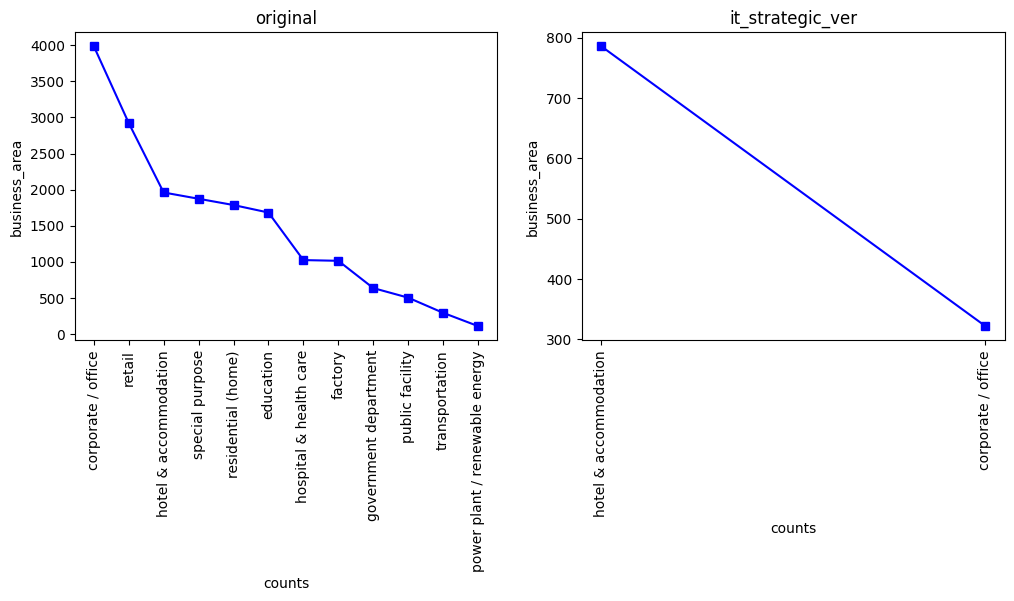

it_strategic_ver 의 데이터 값 :  1108
original 인 경우 ====================
business_area의 결측치 :  37993
it_strategic_ver이 1 인 경우 ====================
business_area의 결측치 :  0



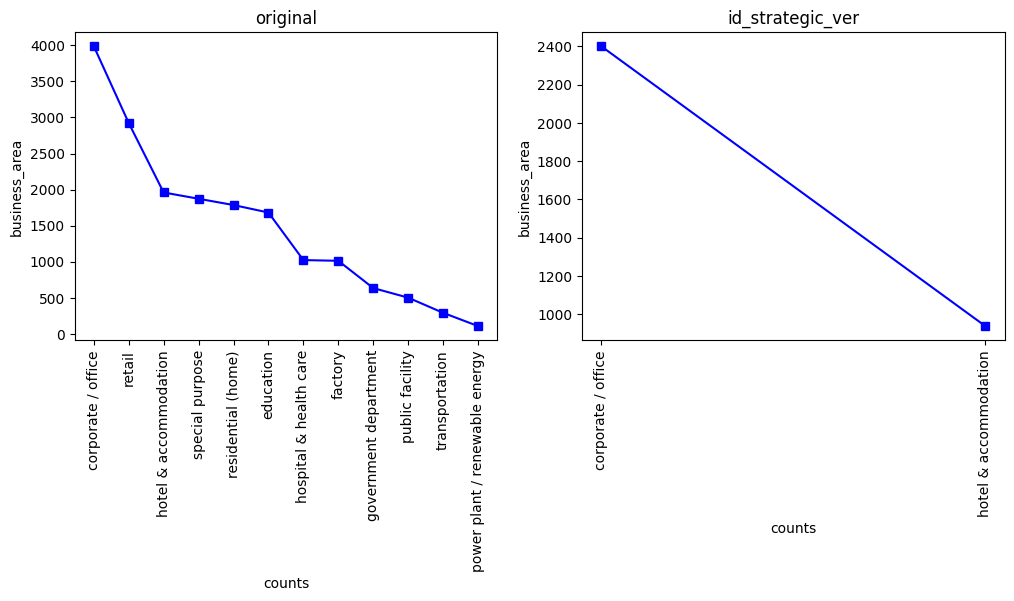

id_strategic_ver 의 데이터 값 :  3339
original 인 경우 ====================
business_area의 결측치 :  37993
id_strategic_ver이 1 인 경우 ====================
business_area의 결측치 :  0



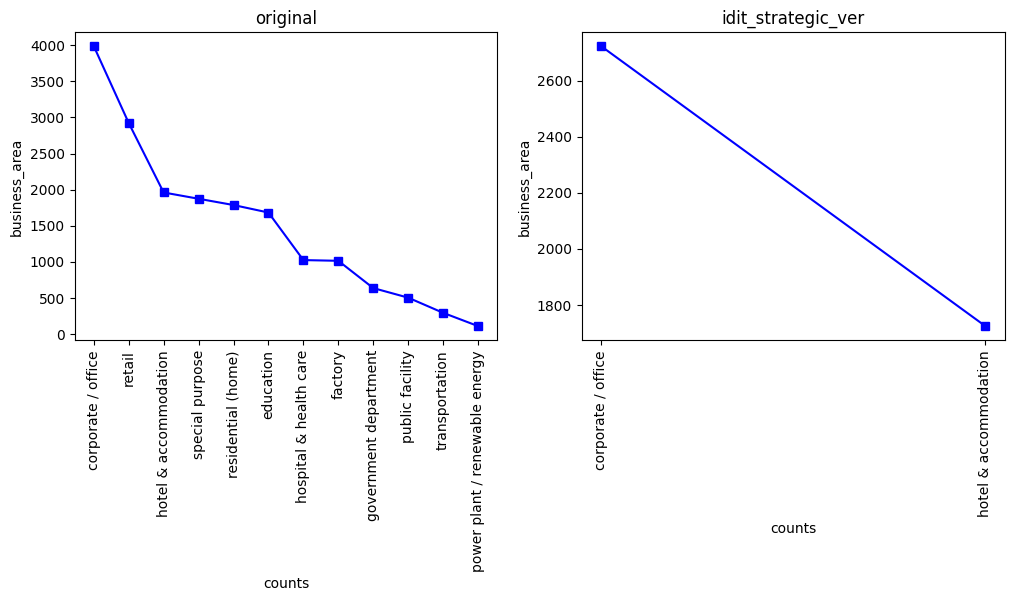

idit_strategic_ver 의 데이터 값 :  4447
original 인 경우 ====================
business_area의 결측치 :  37993
idit_strategic_ver이 1 인 경우 ====================
business_area의 결측치 :  0



In [122]:

#데이터 시각화 코드
def compare_vertical_level(filtering:str, col_name:str):
    '''
    filtering = 1일 때를 나타내는 특정 칼럼
    col_name = 비교하고 싶은 칼럼

    col_name 이 있는지 없는지를 비교

    retunn:none
    '''
    fil = df_train[filtering]==1

    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) #2열 1행

    # original 의 경우
    axes[0].plot(df_train[col_name].value_counts()[:20], 's-b')
    axes[0].set_xlabel('counts')
    axes[0].set_ylabel(col_name)
    axes[0].set_title('original')

    # id_strategic_ver 의 경우
    axes[1].plot(df_train[fil][col_name].value_counts(), 's-b')
    axes[1].set_xlabel('counts')
    axes[1].set_ylabel(col_name)
    axes[1].set_title(filtering)

    for ax in axes:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.show()

    print(f'{filtering} 의 데이터 값 : ', len(df_train[fil]))
    print('original 인 경우','='*20)
    print(f'{col_name}의 결측치 : ', df_train[col_name].isnull().sum())

    print(f'{filtering}이 1 인 경우','='*20)
    print(f'{col_name}의 결측치 : ', df_train[fil][col_name].isnull().sum())

    print('')

compare_vertical_level("it_strategic_ver", 'business_area')

compare_vertical_level('id_strategic_ver', 'business_area')

compare_vertical_level('idit_strategic_ver', 'business_area')



### 2.12.2 데이터 전처리


- 전환율을 확인한 결과, **id_strategic_ver 의 경우 1%의 전환율**을 가지고 있기 때문에 유의미하다고 판단했습니다.

- 이 외에, **'ver_cus' 의 경우 15%의 전환율을, 'ver_pro' 의 경우 9%의 전환율**을 확인하였으며,  두 칼럼 모두 특정 의미를 가지고 있다고 판단하여 데이터 분석에 사용하였습니다.


In [123]:
df_all = pd.concat([df_train[['idit_strategic_ver','business_unit','business_area']], df_test[['idit_strategic_ver','business_unit','business_area']]])


filter1 = df_all['business_area'] == 'hotel & accommodation'
filter2 = df_all['business_area'] == 'corporate / office'

filter3 = df_all['business_unit'] == 'ID'  #
filter4 = df_all['business_unit'] == 'IT'  #

# 결측치 => nan
df_all.loc[df_all['idit_strategic_ver'] != 1,'idit_strategic_ver'] = '0'

# id unit = 'id'
df_all.loc[filter3 & (filter1 | filter2) ,'idit_strategic_ver'] = 'id'

# id unit = 'it'
df_all.loc[filter4 & (filter1 | filter2) ,'idit_strategic_ver'] = 'it'

#df_all[df_all['idit_strategic_ver'] != '0'][['idit_strategic_ver']]

df_train['idit_strategic_ver'] = df_all.iloc[: len(df_train)]['idit_strategic_ver']
df_test['idit_strategic_ver'] = df_all.iloc[len(df_train) :]['idit_strategic_ver']

# 3. 학습에 사용할 칼럼 정의 <a name="3.-학습에-사용할-칼럼-정의"></a>

In [124]:
# 새롭게 바뀐 데이터 자료형

#범주형
label_columns = [
    "customer_country", # customer_country_win_rate (전환율 칼럼) 파생
#    "business_subarea", 제거 all_business_area_details (0, 0.5, 1 범주형)
#    "business_area",제거 (얘가 vertical level 1)
    "business_unit",
    "customer_type", # customer_type_win_rate (전환율 칼럼) 파생
    "enterprise",
    "customer_job", # customer_job_win_rate (전환율 칼럼) 파생
    "inquiry_type", # inquiry_type_win_rate  (전환율 칼럼) 파생
    "product_category", # product_category_win_rate  (전환율 칼럼) 파생
    "product_subcategory", # 제거 all_product_details 로 대체 (0,1 범주형)
    "product_modelname", # 제거 all_product_details 로 대체 (0,1 범주형)
    "customer_position", # customer_position_win_rate (전환율 칼럼) 파생
    "response_corporate", # response_corporate_win_rate (전환율 칼럼) 파생 / country(범주형) / continent(범주형)
    "expected_timeline", # timeline_win_rate (전환율 칼럼) 파생
    'all_product_details', #
    'country',
    'continent',
#   'lead_owner_cat'
]

# 범주형 ( 숫자인데 범주형)
label_columns2 = [
    "bant_submit",
    "customer_idx",
    #"id_strategic_ver", # 0,1 제거
    #"it_strategic_ver", # 0,1 제거
    "idit_strategic_ver", # 0,1
    "ver_cus",# 0, 1
    "ver_pro", # 0, 1
    "lead_owner",
    "all_product_details", # true, false
]

#수치형
numeric_columns = [
    "customer_country_win_rate",
    "timeline_win_rate",
    "product_category_win_rate",
    "customer_type_win_rate",
    "customer_job_win_rate",
    "customer_position_win_rate",
    "response_corporate_win_rate",
   #"historical_existing_cnt",
    "lead_desc_length", # 박스 플롯 upperbound로 이상치 교체 후 train셋의 평균으로 결측 채움
    "com_reg_ver_win_rate", # 결측 트레인 셋 평균으로 대체
    "ver_win_rate_x", # 결측 트레인 셋 평균으로 대체
    "ver_win_ratio_per_bu", # 결측 트레인 셋 평균으로 대체
    "all_business_area_details",
    "inquiry_type_win_rate",
#    "customer_idx_win_rate",
#    "lead_owner_win_rate"
]

# 4. 모델 정의 <a name="4.-모델-정의"></a>


- 전처리 이후의 데이터는 수치형 데이터와 범주형 데이터가 섞여 있습니다.
- 따라서 유형이 다른 두 타입의 데이터를 함께 학습해주기 위해 "DeepFM" 모델을 사용했습니다.
- "DeepFM"은 풍부한 특성 표현과 선형 및 비선형 상호 작용을 고려하기 떄문에 다양한 추천 시스템에서 성능이 우수한 것으로 알려져 있습니다.


  - 모델 논문 링크 : https://arxiv.org/pdf/1703.04247.pdf  
  - 모델 배포 코드 : https://github.com/shenweichen/DeepCTR/blob/master/deepctr/models/deepfm.py  

  - "DeepFM"은 Factorization Machines (FM)와 Neural Networks(DNN)을 결합한 모델로, 사용자와 정보 간의 상호 작용을 모델링할 때 **선형 항목**과 **비선형 항목**을 모두 사용하여 풍부한 특성 표현을 학습합니다. 따라서 해당 train 데이터에서 수치형 데이터와 범주형 데이터를 분리한 다음 훈련을 진행시켰습니다. 하이퍼 파라미터는 모델을 반복적 수행해가며 경험적으로 탐색했습니다.

In [125]:
def feature_selection(data):
    '''
    수치형 데이터를 dense_feature 로,
    범주형 데이터를 sparse_feature 로 구분한다.

    각 feature 별 종류를 출력한다.
    '''
    sparse_features = label_columns + label_columns2
    dense_features = numeric_columns

    print("== sparse feature ==")
    for i, da in enumerate(sparse_features):
        print(i, da)
    print()
    print("== dense feature ==")
    for i,da in enumerate(dense_features):
        print(i, da)
    print()

    return data, sparse_features, dense_features

In [126]:
def feature_encoding(data, train_data, sparse_features, dense_features):
    '''
    sklearn 의 LabelEncoder 로 범주형 데이터의 유형을 숫자로 인코딩한다.
    sklearn 의 MinMaxScaler 로 수치형 데이터의 최소최대값에 따라 정규화한다.

    예측할 test데이터도 함께 진행하지만,
    train 데이터를 기준으로 인코딩 및 정규화하여 data leakage 를 방지하였다.
    '''


    for feat in sparse_features:
        lbe = LabelEncoder()
        #범주형의 경우 사전 전처리에서 이미 test 고유의 데이터 사라짐 (data leakage 방지)
        data[feat] = lbe.fit_transform(data[feat])

    print("1. numeric value Minmax scaling ")
    mms = MinMaxScaler(feature_range=(0, 1))
    # train 값으로만 minmax scaling 하여 data leakage 방지
    mms.fit(train_data[dense_features])

    #결측치 처리를 따로 하지 않은 칼럼의 경우 오류 방지를 위해 0으로 보간
    data[dense_features] = mms.transform(data[dense_features].fillna(0))
    print("2. categorical value label encoding")



    return data


def feature_format_deepfm(data, sparse_features, dense_features, embedding_dim):
    '''
    deepFM 모델을 사용하기 위해서는 SparseFeat 과 DenseFeat 이라는 고유의 class 타입이 필요하다.
    해당 함수는 우리의 수치형 범주형 데이터를 기반으로 두 class 타입을 형성한다.

    '''


    # SparseFeat 코드 사용시 vocabulary 를 학습한다.

    print(f"\n\n3. feature embedding - embedding size {embedding_dim}")

    #이미 인코딩 되어있어서 vocabulary_size 는 데이터 유형의 개수를 파악한다고 볼 수 있다.

    # 각 범주형 칼럼별 데이터 유형의 개수를 파악하고 SparseFeat 클래스로 정의하였다.
    spar_feat_list = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=embedding_dim) for i, feat in enumerate(sparse_features)]
    # 각 수치형 칼럼을 DenseFeat 클래스로 정의
    dense_feat_list = [DenseFeat(feat, 1, ) for feat in dense_features]
    fixlen_feature_columns = spar_feat_list + dense_feat_list

    dnn_feature_columns = fixlen_feature_columns
    linear_feature_columns = fixlen_feature_columns
    feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    return dnn_feature_columns, linear_feature_columns, feature_names

def data_split(data, train_len, test_rato, feature_names, random_seed):
    '''
    학습할 데이터와 평가할 데이터를 분리한다.
    이 때, train_len 인자를 통해 데이터 증강으로 유동적으로 변하는 train 데이터의 갯수를 고려한다.
    '''


    print(f"\n\n4. data split (test ratio - {test_rato})")

    train = data.iloc[: train_len]
    test = data.iloc[train_len :]

    #train, test = train_test_split(data, test_size=test_rato, random_state = random_seed)
    train_model_input = {name: train[name] for name in feature_names}
    test_model_input = {name: test[name] for name in feature_names}

    return train, test, train_model_input, test_model_input


def modeling(linear_feature_columns, dnn_feature_columns,
             batch_size, num_epoch, val_ratio, test_rato, l2_decay_val, random_seed):


    print(f"\n\n5. Modeling")
    #DeepFM 모델을 정의한다.
    #모델에는 dropout 이 사용되었다.
    model = DeepFM(linear_feature_columns=linear_feature_columns,
               dnn_feature_columns=dnn_feature_columns,
               l2_reg_linear=l2_decay_val, l2_reg_embedding=l2_decay_val, l2_reg_dnn=l2_decay_val,
               dnn_dropout=0.5,
               dnn_use_bn = True,
               dnn_hidden_units=(32, 16),
               task='binary',
               seed=random_seed, device=device)


    #이진 분류 모델이기 때문에 binary_crossentropy를 사용했다.
    model.compile("adam", "binary_crossentropy",
                metrics=["binary_crossentropy", "auc"], )


    return model

def eval_test(model, test_model_input, batch_size ):

    print(f"\n\n6. Evaluation testset")

    pred_ans = model.predict(test_model_input, batch_size)
    print("")
    print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
    print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

# 5. 모델 학습 및 평가 <a name="5.-모델-학습-및-평가"></a>

- 모델 학습 시, data imbalance를 고려하여 8%인 전환 데이터 항목을 2배로 증강하였습니다. 증강된 데이터는 총 4620 개 입니다.

증강된 데이터 : 4620 개
== sparse feature ==
0 customer_country
1 business_unit
2 customer_type
3 enterprise
4 customer_job
5 inquiry_type
6 product_category
7 product_subcategory
8 product_modelname
9 customer_position
10 response_corporate
11 expected_timeline
12 all_product_details
13 country
14 continent
15 bant_submit
16 customer_idx
17 idit_strategic_ver
18 ver_cus
19 ver_pro
20 lead_owner
21 all_product_details

== dense feature ==
0 customer_country_win_rate
1 timeline_win_rate
2 product_category_win_rate
3 customer_type_win_rate
4 customer_job_win_rate
5 customer_position_win_rate
6 response_corporate_win_rate
7 lead_desc_length
8 com_reg_ver_win_rate
9 ver_win_rate_x
10 ver_win_ratio_per_bu
11 all_business_area_details
12 inquiry_type_win_rate

1. numeric value Minmax scaling 
2. categorical value label encoding


3. feature embedding - embedding size 1


4. data split (test ratio - 0.1)


5. Modeling
cpu
Train on 48320 samples, validate on 12080 samples, 49 steps per epoch
Epoch 1/

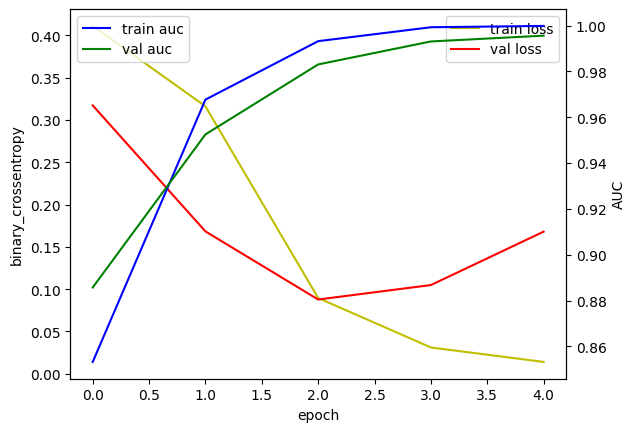

In [127]:

if __name__ == "__main__":
    batch_size = 1000 # 2048
    num_epoch = 5 #20
    val_ratio = 0.2
    test_rato = 0.1
    random_seed = 2022
    l2_decay_val = 1e-01
    embedding_dim = 1

    device = 'cpu'
    use_cuda = True
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'


    #train 중 converted 된 데이터셋 증강
    agument_data = df_train[df_train['is_converted']==1]
    times = 1

    # 증강된 데이터가 누적
    for i in range(times):
        df_train = pd.concat([agument_data, df_train])

    train_len = len(df_train)

    print(f"증강된 데이터 : {len(agument_data)* times} 개")

    #여기서 잠시 합침
    data = pd.concat([df_train, df_test])


    target = ['is_converted']
    data, sparse_features, dense_features = feature_selection(data)
    data = feature_encoding(data, df_train, sparse_features, dense_features) # data -> df_train
    dnn_feature_columns, linear_feature_columns, feature_names = feature_format_deepfm(data, sparse_features, dense_features, embedding_dim) # data -> df_train
    train, test, train_model_input, test_model_input = data_split(data, train_len, test_rato,
                                                                  feature_names, random_seed)
    model = modeling(linear_feature_columns, dnn_feature_columns, batch_size, num_epoch, val_ratio, test_rato, l2_decay_val, random_seed)

    hist  = model.fit(train_model_input,
          train[target].values.astype('float'),
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=2,
          validation_split=val_ratio)


    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['binary_crossentropy'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_binary_crossentropy'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('binary_crossentropy')
    loss_ax.legend(loc='upper right')

    acc_ax.plot(hist.history['auc'], 'b', label='train auc')
    acc_ax.plot(hist.history['val_auc'], 'g', label='val auc')
    acc_ax.set_ylabel('AUC')
    acc_ax.legend(loc='upper left')

    plt.show()


- 위는 다섯 번의 모델 학습을 거친 결과입니다. AUC 를 평가지표로 설정하였으며, 최종 학습 이후, 0.9999의 auc 점수가 나오는 것을 확인했습니다.

In [128]:
def threshold_function(value):
    if value >= 0.1:
        return 1
    else:
        return 0

pred_ans = model.predict(test_model_input) #batch_size default : 256
pred = list(map(threshold_function, pred_ans))

- 모델의 결과값으로는 0에서 1 사이의 확률값이 반환되었고,
데이터 불균형의 문제를 고려하여 전환 확률이 10% 이상인 모든 데이터를
전환으로 예측하였습니다.

In [129]:
# 제출 데이터 읽어오기
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

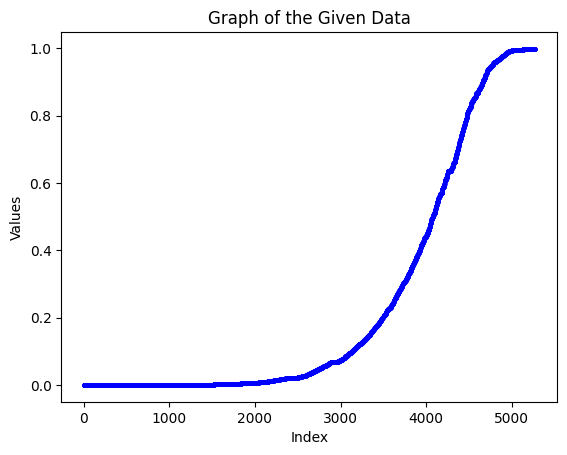

In [130]:
# 그래프 그리기
plt.scatter(range(len(pred_ans)), sorted(pred_ans), marker='o', color='blue',s=5)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Graph of the Given Data')
plt.show()